In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [87]:
from collections import defaultdict
import cPickle as pickle
import glob
import os

fps = sorted(glob.glob(os.path.join('*', 'Sleaze*.pkl')))

model_name_to_score_dicts = defaultdict(dict)
for fp in fps:
    model_name = os.path.split(fp.split('_', 5)[-1])[0]
    with open(fp, 'rb') as f:
        score_dict = pickle.load(f)
        model_name_to_score_dicts[model_name][score_dict['chart_feet']] = score_dict
print model_name_to_score_dicts.keys()

['dnn_diff_both', 'cnn_diff_both', 'dnn', 'logreg', 'cnn', 'logreg_diff_both']


In [92]:
model_names_order = ['logreg', 'dnn', 'cnn', 'logreg_diff_both', 'dnn_diff_both', 'cnn_diff_both']
model_names_clean = ['LogReg', 'DNN', 'CNN', 'LogReg + Diff', 'DNN + Diff', 'CNN + Diff']
diffs = [1, 2, 5, 7, 9]

song_feats = model_name_to_score_dicts[model_names_order[0]][diffs[0]]['song_feats']
song_nfeats = song_feats.shape[0]
print song_nfeats

diff_to_attrs = defaultdict(dict)
for diff in diffs:
    score_dict = model_name_to_score_dicts[model_names_order[0]][diff]
    diff_to_attrs[diff]['gt_onsets'] = score_dict['chart_onsets']
    diff_to_attrs[diff]['first_onset'] = min(score_dict['chart_onsets'])
    diff_to_attrs[diff]['last_onset'] = max(score_dict['chart_onsets'])

onset_min_diff = {}
for diff, attrs in diff_to_attrs.items():
    onsets = attrs['gt_onsets']
    for onset in onsets:
        if onset not in onset_min_diff or onset_min_diff[onset] > diff:
            onset_min_diff[onset] = diff

10914


(5700, 5800)

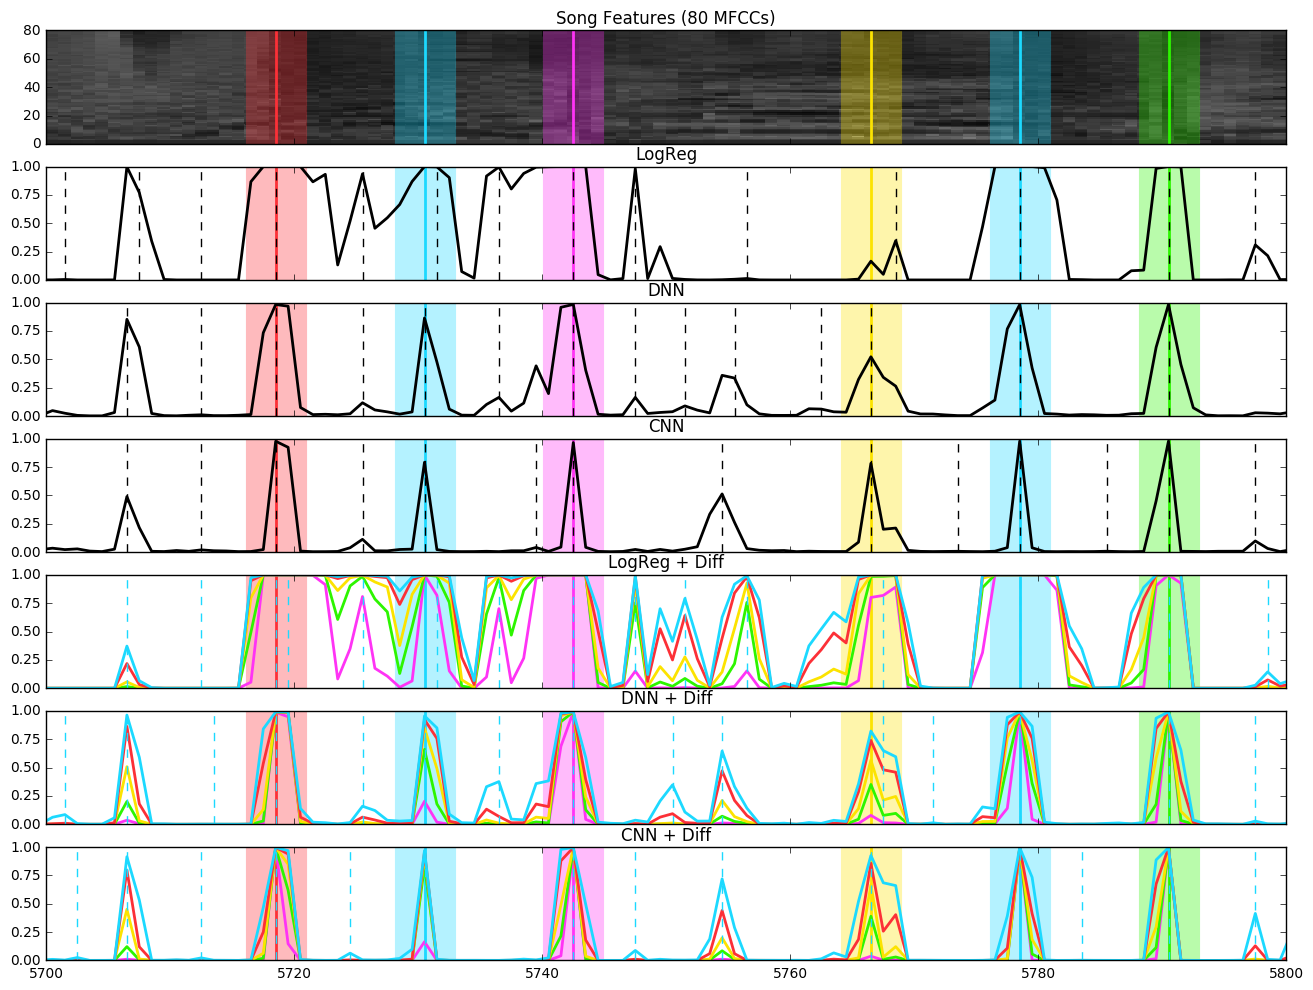

In [210]:
from scipy.signal import argrelextrema
from sklearn.metrics import precision_recall_curve

xmin = 5700
xmax = 5800
diff_to_color = {1: (255, 51, 245), 2: (45, 245, 0), 5: (252, 227, 0), 7: (252, 48, 55), 9: (28, 217, 255)}
diff_to_color = {d: tuple(c / 255.0 for c in t) for d, t in diff_to_color.items()}

f, axarr = plt.subplots(len(model_names_order) + 1, sharex=True, figsize=(16,12))

sx, sy = np.mgrid[slice(0, song_nfeats), slice(0, 80)]
song_feats_plt = np.exp(song_feats)
axarr[0].pcolormesh(sx, sy, song_feats, cmap='Greys')
axarr[0].set_title('Song Features (80 MFCCs)')
axarr[0].set_yticks(np.arange(0.0, 81.0, 20.0))

for ax in axarr:
    for onset, diff in onset_min_diff.items():
        if onset <= xmin or onset >= xmax:
            continue
        ax.axvline(x=(onset + 0.5), linewidth=44, linestyle='-', color=diff_to_color[diff], alpha=0.33)
        ax.axvline(x=(onset + 0.5), linewidth=2, linestyle='-', color=diff_to_color[diff])

for i, (key, label) in enumerate(zip(model_names_order, model_names_clean)):
    score_dicts = model_name_to_score_dicts[key]
    for diff in diffs:
        score_dict = score_dicts[diff]
        assert diff_to_attrs[diff]['gt_onsets'] == score_dict['chart_onsets']
        
        first_onset = diff_to_attrs[diff]['first_onset']
        last_onset = diff_to_attrs[diff]['last_onset']
        
        peaks = [x + first_onset for x in argrelextrema(np.convolve(score_dict['y_scores'], np.hanning(5), 'same'), np.greater_equal)[0]]
        
        color = diff_to_color[diff] if i >= 3 else 'black'
        axarr[i + 1].plot(np.arange(first_onset + 0.5, last_onset + 1 + 0.5), score_dict['y_scores'], color=color, linewidth=2)
        axarr[i + 1].set_title(label)
        axarr[i + 1].set_yticks(np.arange(0.0, 1.1, 0.25))
        
        if diff == 9 or i < 3:
            for peak in peaks:
                if peak <= xmin or peak >= xmax:
                    continue
                axarr[i + 1].axvline(x=peak + 0.5, linewidth=1, linestyle='--', color=color)
        
        precisions, recalls, thresholds = precision_recall_curve(score_dict['y_true'], score_dict['y_scores_pkalgn'])
        fscore_den = precisions + recalls
        fscore_den[np.where(fscore_den == 0.0)] = 1.0
        fscores = (2.0 * (precisions * recalls)) / fscore_den
        best_idx = np.argmax(fscores)
        threshold = thresholds[best_idx]
        
        #axarr[i + 1].axhline(y=threshold, linewidth=1, linestyle='--', color=color)
        
        if i < 3:
            break

axarr[0].set_xlim(xmin, xmax)

(5700, 5800)

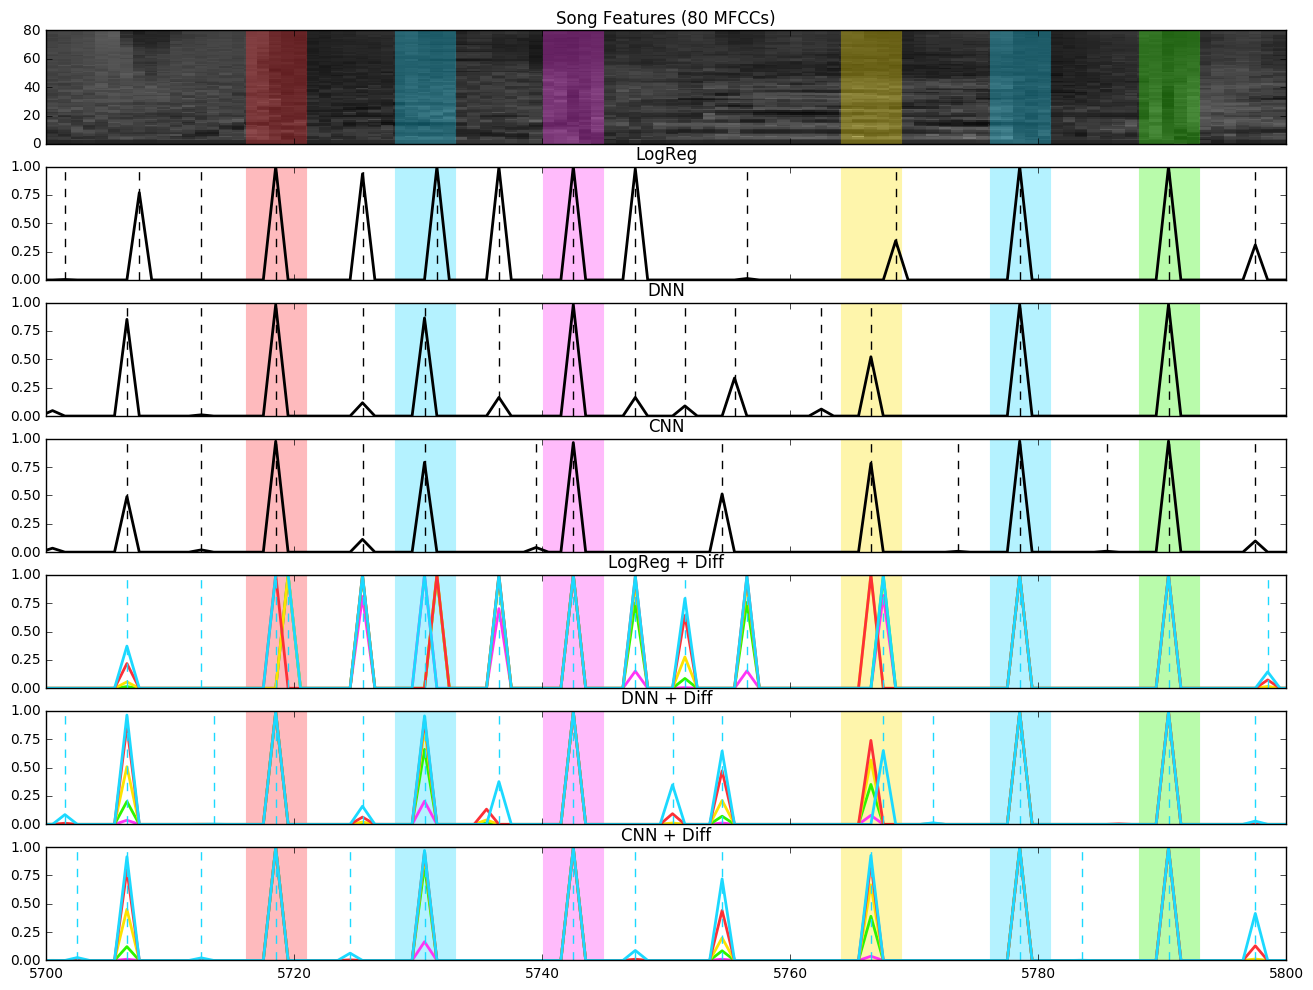

In [196]:
from scipy.signal import argrelextrema
from sklearn.metrics import precision_recall_curve

xmin = 5700
xmax = 5800
diff_to_color = {1: (255, 51, 245), 2: (45, 245, 0), 5: (252, 227, 0), 7: (252, 48, 55), 9: (28, 217, 255)}
diff_to_color = {d: tuple(c / 255.0 for c in t) for d, t in diff_to_color.items()}

f, axarr = plt.subplots(len(model_names_order) + 1, sharex=True, figsize=(16,12))

sx, sy = np.mgrid[slice(0, song_nfeats), slice(0, 80)]
song_feats_plt = np.exp(song_feats)
axarr[0].pcolormesh(sx, sy, song_feats, cmap='Greys')
axarr[0].set_title('Song Features (80 MFCCs)')
axarr[0].set_yticks(np.arange(0.0, 81.0, 20.0))

for ax in axarr:
    for onset, diff in onset_min_diff.items():
        if onset <= xmin or onset >= xmax:
            continue
        ax.axvline(x=(onset + 0.5), linewidth=44, linestyle='-', color=diff_to_color[diff], alpha=0.33)

for i, (key, label) in enumerate(zip(model_names_order, model_names_clean)):
    score_dicts = model_name_to_score_dicts[key]
    for diff in diffs:
        score_dict = score_dicts[diff]
        assert diff_to_attrs[diff]['gt_onsets'] == score_dict['chart_onsets']
        
        first_onset = diff_to_attrs[diff]['first_onset']
        last_onset = diff_to_attrs[diff]['last_onset']
        
        color = diff_to_color[diff] if i >= 3 else 'black'
        axarr[i + 1].plot(np.arange(first_onset + 0.5, last_onset + 1 + 0.5), score_dict['y_scores_pkalgn'], color=color, linewidth=2)
        axarr[i + 1].set_title(label)
        axarr[i + 1].set_yticks(np.arange(0.0, 1.1, 0.25))
        
        if diff == 9 or i < 3:
            for peak in np.where(score_dict['y_scores_pkalgn'] > 0.0)[0]:
                peak = peak + first_onset
                if peak <= xmin or peak >= xmax:
                    continue
                axarr[i + 1].axvline(x=peak + 0.5, linewidth=1, linestyle='--', color=color)
        
        precisions, recalls, thresholds = precision_recall_curve(score_dict['y_true'], score_dict['y_scores_pkalgn'])
        fscore_den = precisions + recalls
        fscore_den[np.where(fscore_den == 0.0)] = 1.0
        fscores = (2.0 * (precisions * recalls)) / fscore_den
        best_idx = np.argmax(fscores)
        threshold = thresholds[best_idx]
        
        #axarr[i + 1].axhline(y=threshold, linewidth=1, linestyle='--', color=color)
        
        if i < 3:
            break

axarr[0].set_xlim(xmin, xmax)

In [48]:
idxs = (7010, 7040)
idxs = tuple(x + first_onset for x in idxs)
print score_dicts[3]['y_scores'][idxs[0]:idxs[1]]

[  9.99998808e-01   3.83590907e-02   6.07489126e-09   9.64560463e-15
   5.19962398e-15   1.91576922e-16   2.14098229e-15   1.40543891e-14
   3.48221612e-08   1.55148832e-02   9.99978781e-01   1.00000000e+00
   1.00000000e+00   9.99998569e-01   1.58599302e-01   1.43906008e-03
   8.65751319e-03   6.64789826e-02   1.59428660e-02   1.33830166e-04
   2.36093509e-03   7.85868540e-02   9.99892950e-01   1.00000000e+00
   9.99999881e-01   3.30292605e-05   2.36667044e-12   1.89119863e-15
   4.52051108e-15   2.95248682e-14]
